In [99]:
import torch

a = torch.tensor([1, 2, 3, 4])
print(a)
print(type(a))
print(a.dtype)
print(a.shape)
b = torch.tensor([1, 2, 3.1, 4])
print(b.dtype)
print(b)

tensor([1, 2, 3, 4])
<class 'torch.Tensor'>
torch.int64
torch.Size([4])
torch.float32
tensor([1.0000, 2.0000, 3.1000, 4.0000])


In [100]:
A = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(A)
print(A.shape)
print(A.ndim) # 차원의 수
print(A.numel()) # 전체 행렬의 수

tensor([[1, 2, 3],
        [4, 5, 6]])
torch.Size([2, 3])
2
6


In [101]:
print(torch.zeros(3, 4))
print(torch.zeros_like(A))
print(torch.arange(1, 10, 3))
print(torch.linspace(0, 1, 10)) # linearspace 0~1 까지 10개 만들어줘

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0, 0, 0],
        [0, 0, 0]])
tensor([1, 4, 7])
tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])


In [102]:
A = torch.tensor([[1, 2], [4, 5]])
B = torch.tensor([[1, 2], [4, 5]])
print(A*B) # hadammar product?
print(A@B) # np.dot

tensor([[ 1,  4],
        [16, 25]])
tensor([[ 9, 12],
        [24, 33]])


In [103]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

dataset = pd.read_csv('./data/car_evaluation.csv')
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [104]:
print(dataset.columns)

Index(['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety',
       'output'],
      dtype='object')


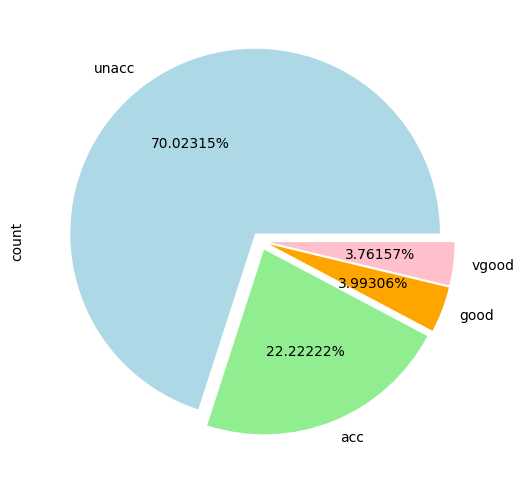

In [105]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset['output'].value_counts().plot(
    kind='pie', 
    autopct="%0.05f%%",
    colors = ['lightblue', 'lightgreen', 'orange', 'pink'], 
    explode=((0.05,0.05,0.05,0.05,))
)
plt.show()

In [106]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [107]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [108]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs).flatten()

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([6912])


In [109]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size + 1)//2))for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [110]:
total_records = 1728
test_records = int(total_records * 0.2)

categorical_train_data = categorical_data[:total_records - test_records]
categorical_test_data = categorical_data[total_records - test_records:total_records]
train_outputs = outputs[:total_records - test_records]
test_outputs = outputs[total_records - test_records:total_records]

print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [111]:
class Model(nn.Module):

    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList(
            [nn.Embedding(ni, nf) for ni, nf in embedding_size]
        )
        self.embeddings_dropout = nn.Dropout(p)

        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols

        for i in layers:
            print(i)
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i
        
        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    
    def forward(self, x_categorical):
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:, i]))
        x = torch.cat(embeddings, 1)
        x = self.embeddings_dropout(x)
        x = self.layers(x)
        return x

In [112]:
model = Model(
    embedding_size=categorical_embedding_sizes, 
    output_size=4, 
    layers=[200,100,50], 
    p=0.4
)
print(model)

200
100
50
Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [113]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [114]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [115]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)

for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f"epoch: {i:3} loss: {single_loss.item():10.8f}")
    
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f"epoch: {i:3} loss: {single_loss.item():10.10f}")

epoch:   1 loss: 1.58092022
epoch:  26 loss: 1.34614992
epoch:  51 loss: 1.25525367
epoch:  76 loss: 1.17887712
epoch: 101 loss: 1.04190814
epoch: 126 loss: 0.92367762
epoch: 151 loss: 0.81266540
epoch: 176 loss: 0.74886578
epoch: 201 loss: 0.69469184
epoch: 226 loss: 0.64604765
epoch: 251 loss: 0.62872452
epoch: 276 loss: 0.62439823
epoch: 301 loss: 0.60322511
epoch: 326 loss: 0.60499078
epoch: 351 loss: 0.59090048
epoch: 376 loss: 0.59295255
epoch: 401 loss: 0.58119571
epoch: 426 loss: 0.58305264
epoch: 451 loss: 0.58785039
epoch: 476 loss: 0.58290827
epoch: 500 loss: 0.5715540051


In [120]:
categorical_test_data = categorical_test_data.to(device=device, dtype=torch.int64)
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
model = model.to(device)

with torch.no_grad():
    y_test_pred = model(categorical_test_data)
    test_loss = loss_function(y_test_pred, test_outputs)

print(f"Test loss: {test_loss.item():10.8f}")

Test loss: 0.57012165
